In [142]:
from pycm import *
from matplotlib import pyplot as plt
from easydict import EasyDict as edict
from module.class_names import class_names
from torchvision import transforms
from torch.nn import functional as F
from module.models import create_model
from module.utils import metrics_report_to_df, save_plot_cm, prec_score, \
                        recc_score, acc_score, fone_score, classification_reports, set_seeds, precision_recall_fscore_support
from pycm import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import os
import time
import torch
import numpy as np
import yaml
import glob as glob
import cv2
import argparse

In [127]:
class_names

['beige',
 'black',
 'blue',
 'brown',
 'gold',
 'green',
 'grey',
 'orange',
 'pink',
 'purple',
 'red',
 'silver',
 'tan',
 'white',
 'yellow']

In [128]:
init = set_seeds()
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(f"Computation device: {device}")

Computation device: cuda:0


In [129]:
def transform(image):
    transformation = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                    std=[0.229, 0.224, 0.225])
            ])
    return transformation(image)

In [130]:
color_path = f"../Inference/best_models/color.pth" 
pku_path = f"../Inference/best_models/pku.pth" 
stanford_path = f"../Inference/best_models/stanford.pth" 

In [131]:
color = create_model(model_name = 'densenet_201' , num_classes = 15).to(device)
color.eval()

[INFO]: Freezing hidden layers...


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [132]:
print(color.load_state_dict(torch.load(color_path, 
                                    map_location=device)['model_state_dict'], 
                                   ))

<All keys matched successfully>


In [133]:
test_path = '../Dataset/Vehicle-Color/test/*/*.jpg'
test_images = glob.glob(test_path, recursive=True)
len(test_images)

1556

In [137]:
from tqdm import tqdm

y_true = []
y_pred  = []
t0 = time.time()
for image_path in tqdm(test_images):
    image = cv2.imread(image_path)
    actual_class_name = image_path.split(os.path.sep)[-2]
    original_image = image.copy()

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, channel = original_image.shape

    image_tensor = transform(image)
    image_tensor = image_tensor.unsqueeze(0).to(device)

    start_time = time.time()

    with torch.no_grad():      
        outputs = color(image_tensor)
      
    end_time = time.time()

    probs = F.softmax(outputs, dim=1)
    conf, classes = torch.max(probs, 1)
    conf_score = float(conf.item())
    class_idx = int(classes.item())
    pred_class_name = str(class_names[int(class_idx)])

    y_true.append(actual_class_name)
    y_pred.append(pred_class_name)

#     print(f"Actual: {actual_class_name} / Prediction: {pred_class_name} ({conf_score})")
#     print(f"Inference Time: {(end_time - start_time)*1000 :.3f} ms.")

100%|██████████| 1556/1556 [08:25<00:00,  3.08it/s]


In [140]:
print(f"Precision score (weighted): {prec_score(y_true, y_pred, class_names):.4f}")
print(f"Recall score (weighted): {recc_score(y_true, y_pred, class_names):.4f}")
print(f"Accuracy score (weighted): {acc_score(y_true, y_pred):.4f}")
print(f"F1 Score score (weighted): {fone_score(y_true, y_pred, class_names):.4f}")
print(f"PRSF: {precision_recall_fscore_support(y_true, y_pred)}")
print(f"Clssification report:\n")
print(classification_reports(y_true, y_pred, class_names))

Precision score (weighted): 0.8736
Recall score (weighted): 0.8702
Accuracy score (weighted): 0.8702
F1 Score score (weighted): 0.8675
PRSF: (array([0.546875  , 0.92045455, 0.97484277, 0.87288136, 0.80645161,
       0.975     , 0.76699029, 0.90350877, 0.95876289, 0.97435897,
       0.87586207, 0.76      , 0.65306122, 0.87234043, 0.98305085]), array([0.77777778, 0.93103448, 0.97484277, 0.85123967, 0.55555556,
       0.96694215, 0.85869565, 0.90350877, 0.90291262, 0.99130435,
       0.93382353, 0.74025974, 0.37209302, 0.95348837, 0.93548387]), array([0.64220183, 0.92571429, 0.97484277, 0.86192469, 0.65789474,
       0.97095436, 0.81025641, 0.90350877, 0.93      , 0.98275862,
       0.90391459, 0.75      , 0.47407407, 0.91111111, 0.95867769]), array([ 90,  87, 159, 121,  45, 121,  92, 114, 103, 115, 136,  77,  86,
        86, 124]))
Clssification report:

              precision    recall  f1-score   support

       beige       0.55      0.78      0.64        90
       black       0.92   

In [145]:
cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[ 70,   1,   0,   3,   0,   0,   0,   0,   0,   0,   0,   1,  14,
          1,   0],
       [  0,  81,   0,   0,   0,   0,   6,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0, 155,   0,   0,   0,   2,   0,   0,   2,   0,   0,   0,
          0,   0],
       [  7,   1,   1, 103,   1,   1,   2,   3,   0,   0,   0,   1,   0,
          1,   0],
       [  5,   2,   0,   7,  25,   0,   0,   0,   1,   1,   0,   0,   3,
          0,   1],
       [  0,   0,   2,   0,   0, 117,   1,   1,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   3,   0,   0,   0,   0,  79,   0,   0,   0,   0,   9,   0,
          1,   0],
       [  0,   0,   0,   2,   0,   0,   0, 103,   0,   0,   8,   0,   0,
          0,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0,  93,   0,  10,   0,   0,
          0,   0],
       [  0,   0,   1,   0,   0,   0,   0,   0,   0, 114,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   1,   5,   3,   0, 127,   0,   0,
       

In [147]:
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
FP, FN, TP, TN

(array([58.,  7.,  4., 15.,  6.,  3., 24., 11.,  4.,  3., 18., 18., 17.,
        12.,  2.]),
 array([20.,  6.,  4., 18., 20.,  4., 13., 11., 10.,  1.,  9., 20., 54.,
         4.,  8.]),
 array([ 70.,  81., 155., 103.,  25., 117.,  79., 103.,  93., 114., 127.,
         57.,  32.,  82., 116.]),
 array([1408., 1462., 1393., 1420., 1505., 1432., 1440., 1431., 1449.,
        1438., 1402., 1461., 1453., 1458., 1430.]))

In [153]:
ACC = (TP+TN)/(TP+FP+FN+TN)
sum(ACC)/15

0.9826906598114824

In [155]:
P = TP/(TP+FP)
sum(P) / 15

0.8562960514786201

In [156]:
R = TP/(TP+FN)
sum(R) / 15

0.8432641553897667

In [69]:
cm = ConfusionMatrix(actual_vector=y_true, predict_vector=y_pred)

In [70]:
cm.classes

['beige',
 'black',
 'blue',
 'brown',
 'gold',
 'green',
 'grey',
 'orange',
 'pink',
 'purple',
 'red',
 'silver',
 'tan',
 'white',
 'yellow']

In [72]:
cm

pycm.ConfusionMatrix(classes: ['beige', 'black', 'blue', 'brown', 'gold', 'green', 'grey', 'orange', 'pink', 'purple', 'red', 'silver', 'tan', 'white', 'yellow'])

In [89]:
cm.print_matrix()

Predict      beige        black        blue         brown        gold         green        grey         orange       pink         purple       red          silver       tan          white        yellow       
Actual
beige        70           1            0            3            0            0            0            0            0            0            0            1            14           1            0            

black        0            81           0            0            0            0            6            0            0            0            0            0            0            0            0            

blue         0            0            155          0            0            0            2            0            0            2            0            0            0            0            0            

brown        7            1            1            103          1            1            2            3            0            0            0          

/opt/conda/lib/python3.8/site-packages/pycm/pycm_obj.py:136: RuntimeWarning: The confusion matrix is a high dimension matrix and won't be demonstrated properly.
If confusion matrix has too many zeros (sparse matrix) you can set `sparse` flag to True in printing functions otherwise by using save_csv method to save the confusion matrix in csv format you'll have better demonstration.
  warn(CLASS_NUMBER_WARNING, RuntimeWarning)


In [15]:
print(cm)

Predict      beige        black        blue         brown        gold         green        grey         orange       pink         purple       red          silver       tan          white        yellow       
Actual
beige        70           1            0            3            0            0            0            0            0            0            0            1            14           1            0            

black        0            81           0            0            0            0            6            0            0            0            0            0            0            0            0            

blue         0            0            155          0            0            0            2            0            0            2            0            0            0            0            0            

brown        7            1            1            103          1            1            2            3            0            0            0          

/opt/conda/lib/python3.8/site-packages/pycm/pycm_obj.py:217: RuntimeWarning: The confusion matrix is a high dimension matrix and won't be demonstrated properly.
If confusion matrix has too many zeros (sparse matrix) you can set `sparse` flag to True in printing functions otherwise by using save_csv method to save the confusion matrix in csv format you'll have better demonstration.
  warn(CLASS_NUMBER_WARNING, RuntimeWarning)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

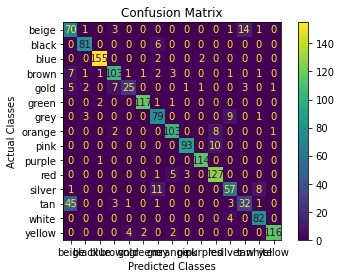

In [43]:
cm.plot(cmap=plt.cm.viridis, number_label=True, plot_lib="matplotlib")

In [170]:
cm

pycm.ConfusionMatrix(classes: ['beige', 'black', 'blue', 'brown', 'gold', 'green', 'grey', 'orange', 'pink', 'purple', 'red', 'silver', 'tan', 'white', 'yellow'])

In [171]:
sum(P) / len(P)

0.8562960514786201

In [179]:
TP  = sum(cm.TP.values())
TP/15

0.8701799485861182

In [182]:
cm.FP.values()

dict_values([58, 7, 4, 15, 6, 3, 24, 11, 4, 3, 18, 18, 17, 12, 2])

In [173]:
TN  = sum(cm.TN.values())
TN

21582

In [174]:
FP = sum(cm.FP.values())
FP

202

In [175]:
FN  = sum(cm.FN.values())
FN

202

In [176]:
acc = (TP+TN) / (TP+FP+FN+TN)
acc

0.9826906598114824

In [177]:
P = TP/(TP+FP)
P

0.8701799485861182

In [178]:
R = TP/(TP+FN)
R

0.8701799485861182

In [125]:
F1 = 2 * (P*R/(P+R))
F1

0.8701799485861181